In [1]:
import numpy as np
import torch_geometric
print(torch_geometric.__version__)

def calculate_force(particle1, particle2):
    dx = particle2[0] - particle1[0]
    dy = particle2[1] - particle1[1]
    r_squared = dx**2 + dy**2
    
    if r_squared == 0:
        return [0, 0]  # Avoid division by zero
    
    force_magnitude = particle1[2] * particle2[2] / r_squared
    force_x = force_magnitude * dx / np.sqrt(r_squared)
    force_y = force_magnitude * dy / np.sqrt(r_squared)
    
    return [force_x, force_y]

def generate_particle_dataset(num_points):
    dataset = []
    
    for _ in range(num_points):
        data_point = []
        positions = set()
        
        # Generate 3 particles with unique positions
        for _ in range(3):
            while True:
                x = np.random.uniform(0, 1)
                y = np.random.uniform(0, 1)
                position = (round(x, 6), round(y, 6))
                
                if position not in positions:
                    positions.add(position)
                    break
            
            # mass = np.random.uniform(0.5, 10) # Commented to make training easier for now
            mass = 1
            particle = [x, y, mass, [0, 0]]  # [x, y, mass, [force_x, force_y]]
            data_point.append(particle)
        
        # Calculate forces
        for i in range(3):
            for j in range(3):
                if i != j:
                    force = calculate_force(data_point[i], data_point[j])
                    data_point[i][3][0] += force[0]
                    data_point[i][3][1] += force[1]
        
        dataset.append(data_point)
    
    return dataset

# Generate a dataset with 100 data points
num_points = 20
particle_dataset = generate_particle_dataset(num_points)

# Print the first few data points as an example
for i, data_point in enumerate(particle_dataset[:3]):
    print(f"Data point {i + 1}:")
    for j, particle in enumerate(data_point):
        print(f"  Particle {j + 1}: [x = {particle[0]:.6f}, y = {particle[1]:.6f}, mass = {particle[2]:.4f}, force = [{particle[3][0]:.6e}, {particle[3][1]:.6e}]]")
    print()

2.5.3
Data point 1:
  Particle 1: [x = 0.035621, y = 0.112218, mass = 1.0000, force = [2.114678e+00, 6.798329e-01]]
  Particle 2: [x = 0.808203, y = 0.587166, mass = 1.0000, force = [7.198951e-01, -4.691735e+00]]
  Particle 3: [x = 0.997219, y = 0.150610, mass = 1.0000, force = [-2.834574e+00, 4.011902e+00]]

Data point 2:
  Particle 1: [x = 0.224972, y = 0.617152, mass = 1.0000, force = [1.137136e+01, -5.640398e+00]]
  Particle 2: [x = 0.860780, y = 0.417761, mass = 1.0000, force = [-9.472674e+00, 1.738772e+00]]
  Particle 3: [x = 0.497014, y = 0.470651, mass = 1.0000, force = [-1.898685e+00, 3.901626e+00]]

Data point 3:
  Particle 1: [x = 0.359440, y = 0.505908, mass = 1.0000, force = [5.593314e+00, -1.690895e+00]]
  Particle 2: [x = 0.666433, y = 0.631527, mass = 1.0000, force = [-9.869247e+00, -4.847443e+00]]
  Particle 3: [x = 0.160539, y = 0.143684, mass = 1.0000, force = [4.275933e+00, 6.538338e+00]]



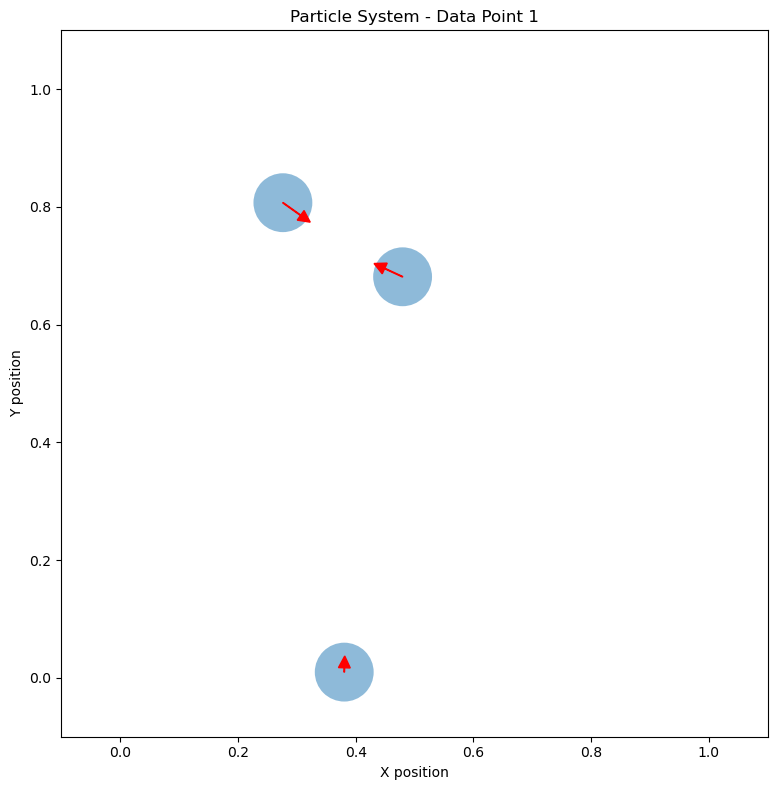

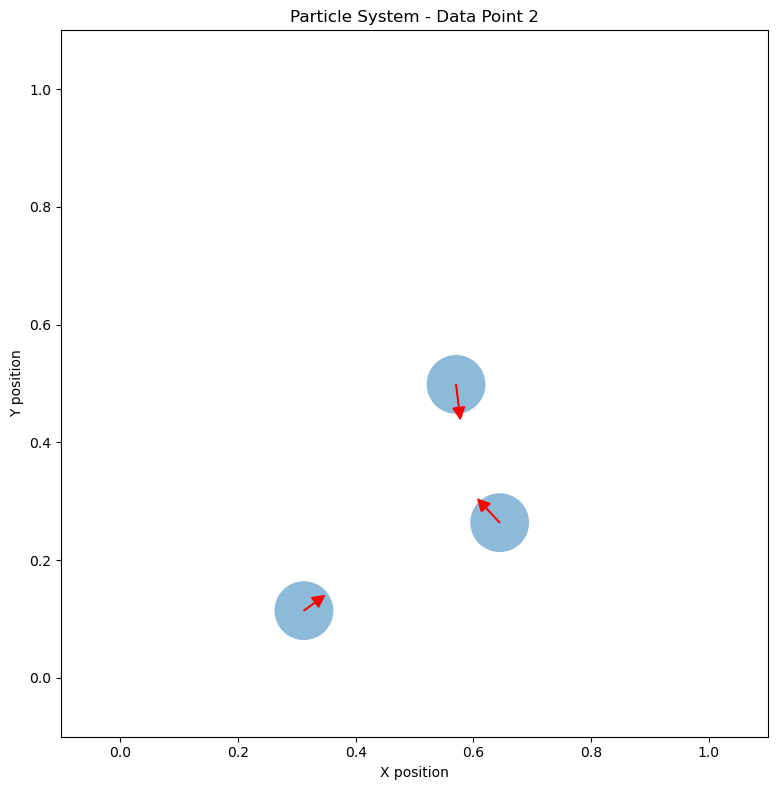

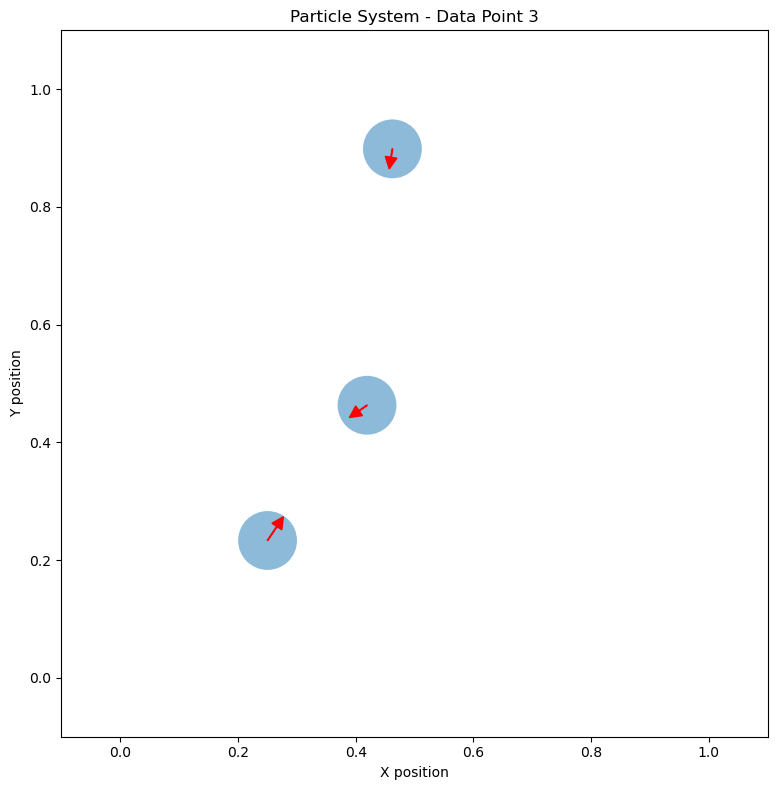

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_particle_system(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        size = 50 * (mass / max_mass)  # Scale size relative to maximum mass
        circle = plt.Circle((x, y), radius=size/1000, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.002
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                    head_width=0.02, head_length=0.02, fc='r', ec='r')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Assuming particle_dataset is already generated
# Plot the first 3 data points
for i, data_point in enumerate(particle_dataset[:3]):
    plot_particle_system(data_point, i+1)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

class EdgeModel(MessagePassing):
    def __init__(self):
        super(EdgeModel, self).__init__(aggr='add')  # "Add" aggregation.
        self.mlp = nn.Sequential(
            nn.Linear(6, 300),  # 6 = 2 (pos) + 1 (mass) for each particle
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 2)  # Output 2D force
        )

    def forward(self, x, edge_index):
        # print("edge index: ", edge_index)
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j], dim=1)  # Concatenate features of both nodes
        # print(tmp)
        out = self.mlp(tmp)
        # print("out: ", out)
        return out

class NodeModel(nn.Module):
    def __init__(self):
        super(NodeModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(5, 32),  # 5 = 2 (pos) + 1 (mass) + 2 (aggregated force)
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Output 2D force
        )

    def forward(self, x, edge_index, edge_attr):
        # The edge attributes have already been added when the Message Passing layer was
        # applied. Simply concatenate them with the node's features.
        # print("edge attributes: ", edge_attr)
        out = torch.cat([x, edge_attr], dim=1)
        return self.mlp(out)

class ParticleGNN(nn.Module):
    def __init__(self):
        super(ParticleGNN, self).__init__()
        self.edge_model = EdgeModel()
        self.node_model = NodeModel()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Edge Model
        edge_attr = self.edge_model(x, edge_index)
        
        # Node Model
        out = self.node_model(x, edge_index, edge_attr)
        
        return out

# Create a sample input
def create_sample_data(num_particles=3):
    x = torch.rand(num_particles, 3)  # [x, y, mass] for each particle
    edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                               [1, 2, 0, 2, 0, 1]], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    return data

# Initialize the model
model = ParticleGNN()

# Create sample data
data = create_sample_data()
print(data)
print("node info: ", data.x)

# Forward pass
output = model(data)

print("Input:")
print(data.x)
print("\nOutput (forces):")
print(output)


Data(x=[3, 3], edge_index=[2, 6])
node info:  tensor([[0.6913, 0.8595, 0.2865],
        [0.0132, 0.2312, 0.8751],
        [0.9878, 0.1292, 0.5999]])
Input:
tensor([[0.6913, 0.8595, 0.2865],
        [0.0132, 0.2312, 0.8751],
        [0.9878, 0.1292, 0.5999]])

Output (forces):
tensor([[ 0.1273, -0.0864],
        [ 0.1070, -0.1043],
        [ 0.0964, -0.1263]], grad_fn=<AddmmBackward0>)


In [4]:
x_dataset = []
y_dataset = []
edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                           [1, 2, 0, 2, 0, 1]], dtype=torch.long)
for data_point in particle_dataset:
    x = torch.tensor([particle[:3] for particle in data_point], dtype=torch.float32)
    y = torch.tensor([particle[3] for particle in data_point], dtype=torch.float32)
    x_dataset.append(Data(x=x, edge_index=edge_index))
    y_dataset.append(y)


for particle in particle_dataset[:2]:
    print(particle)

print("\n")

for x in x_dataset[:2]:
    print(x.x)

print("\n")

for y in y_dataset[:2]:
    print(y)

[[0.2762717926259951, 0.8071924043371272, 1, [15.069823751819335, -10.73599674149896]], [0.4796124383725794, 0.6813434368959782, 1, [-15.186434372875752, 7.056240427354712]], [0.3804600643385596, 0.009759474461445872, 1, [0.11661062105641568, 3.6797563141442486]]]
[[0.6445674205021634, 0.2636802936195708, 1, [-11.819941499937496, 12.6374514356598]], [0.31195386857504803, 0.114162882835939, 1, [9.459033756142857, 6.95038040184367]], [0.5704386932796078, 0.4985562931806258, 1, [2.360907743794639, -19.587831837503472]]]


tensor([[0.2763, 0.8072, 1.0000],
        [0.4796, 0.6813, 1.0000],
        [0.3805, 0.0098, 1.0000]])
tensor([[0.6446, 0.2637, 1.0000],
        [0.3120, 0.1142, 1.0000],
        [0.5704, 0.4986, 1.0000]])


tensor([[ 15.0698, -10.7360],
        [-15.1864,   7.0562],
        [  0.1166,   3.6798]])
tensor([[-11.8199,  12.6375],
        [  9.4590,   6.9504],
        [  2.3609, -19.5878]])


In [7]:
import torch
import torch.optim as optim

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
model = model.to(device)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training loop
num_epochs = 3000  # Define the number of epochs
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    for x, y in zip(x_dataset, y_dataset):
        # Move data to the device
        x = x.to(device)
        y = y.to(device)
        
        # Forward pass
        output = model(x)
        
        # Compute loss
        loss = criterion(output, y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Print loss for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# After training, the model is ready for evaluation or further use
print("Training complete!")

Using device: cuda
Epoch [10/3000], Loss: 3.4994
Epoch [20/3000], Loss: 3.4993
Epoch [30/3000], Loss: 3.4992
Epoch [40/3000], Loss: 3.4992
Epoch [50/3000], Loss: 3.4992
Epoch [60/3000], Loss: 3.4992
Epoch [70/3000], Loss: 3.4992
Epoch [80/3000], Loss: 3.4992
Epoch [90/3000], Loss: 3.4992
Epoch [100/3000], Loss: 3.4992
Epoch [110/3000], Loss: 3.4992
Epoch [120/3000], Loss: 3.4992
Epoch [130/3000], Loss: 3.4992
Epoch [140/3000], Loss: 3.4992
Epoch [150/3000], Loss: 3.4992
Epoch [160/3000], Loss: 3.4992
Epoch [170/3000], Loss: 3.4992
Epoch [180/3000], Loss: 3.4992
Epoch [190/3000], Loss: 3.4992
Epoch [200/3000], Loss: 3.4992
Epoch [210/3000], Loss: 3.4992
Epoch [220/3000], Loss: 3.4992
Epoch [230/3000], Loss: 3.4992
Epoch [240/3000], Loss: 3.4992
Epoch [250/3000], Loss: 3.4992
Epoch [260/3000], Loss: 3.4992
Epoch [270/3000], Loss: 3.4992
Epoch [280/3000], Loss: 3.4992
Epoch [290/3000], Loss: 3.4992
Epoch [300/3000], Loss: 3.4992
Epoch [310/3000], Loss: 3.4992
Epoch [320/3000], Loss: 3.499

In [56]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.grad.norm())

edge_model.mlp.0.weight tensor(8.0780)
edge_model.mlp.0.bias tensor(0.4546)
edge_model.mlp.2.weight tensor(2.3525)
edge_model.mlp.2.bias tensor(0.2090)
edge_model.mlp.4.weight tensor(0.6938)
edge_model.mlp.4.bias tensor(0.0802)
edge_model.mlp.6.weight tensor(1.5768)
edge_model.mlp.6.bias tensor(0.1149)
edge_model.mlp.8.weight tensor(1.9439)
edge_model.mlp.8.bias tensor(0.1977)
edge_model.mlp.10.weight tensor(1.0382)
edge_model.mlp.10.bias tensor(0.0843)
edge_model.mlp.12.weight tensor(1.2645)
edge_model.mlp.12.bias tensor(0.1333)
edge_model.mlp.14.weight tensor(1.0933)
edge_model.mlp.14.bias tensor(0.2495)
node_model.mlp.0.weight tensor(2.2423)
node_model.mlp.0.bias tensor(0.4217)
node_model.mlp.2.weight tensor(1.0999)
node_model.mlp.2.bias tensor(0.1077)
node_model.mlp.4.weight tensor(0.9018)
node_model.mlp.4.bias tensor(0.0403)
